In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ape import accounts, chain, Contract, networks, project

In [3]:
# SEE: https://gist.github.com/banteg/dcf6082ff7fc6ad51ce220146f29d9ff
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [68]:
# mrgl v1 constants
MAINTENANCE_UNIT = int(1e6)
SECONDS_AGO = 43200  # 12 hr TWAP

In [28]:
# UNI/WETH from Feb 27, 2023 to  26, 2024
FILEPATH = "results/MarginalV1LPRunner_0x1d42064Fc4Beb5F8aAF85F4617AE8b3b5B8Bd801_250000_0.25_0.25_3.5_0_50400_0.005_17998181_19311400_2400.csv"

In [35]:
[
    _,
    pool_addr,
    maintenance,
    utilization,
    skew,
    leverage,
    rel_margin_above_safe_min,
    blocks_held,
    sqrt_price_tol,
    start,
    stop,
    step
] = re.split("_", FILEPATH[len("results/"):-len(".csv")])

In [36]:
maintenance = int(maintenance)
utilization = float(utilization)
skew = float(skew)
leverage = float(leverage)
rel_margin_above_safe_min = float(rel_margin_above_safe_min)
blocks_held = int(blocks_held)
sqrt_price_tol = float(sqrt_price_tol)
start = int(start)
stop = int(stop)
step = int(step)

In [37]:
leverage

3.5

In [43]:
# values array from backtester for marginal LP pool
# values = [liquidity, sqrtPriceX96, liquidityLocked, lpTotalLiquidity, lpAmount0, lpAmount1]
df = pd.read_csv(FILEPATH)
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,_net_liquidity_liquidated_cumulative0,_net_liquidity_liquidated_cumulative1,_net_liquidity_settled_cumulative0,_net_liquidity_settled_cumulative1,_balances_pool0,_balances_pool1,_last_mrglv1_block_timestamp,_last_mrglv1_tick_cumulative,_net_liquidity_swap_fees_cumulative,_net_liquidity_position_fees_cumulative
0,17998182,1708998584,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,0,0,0,0,0,0,-1,-1,0,0
1,18000582,1708998588,7670480545305599283587,4167684945538446847935294040,2556722172638830439092,10227202717944329718739,194420281185370240489050,537987471246382048461,4174832966775960060884034990,1348756457373625844877604,...,0,0,0,0,194065277576750292549332,552889053808695116370,1708998587,-236748,56581701727828008,327866112482406212
2,18002982,1709027524,7670499743743404731727,4167695376832776717667634751,2556722172638830439092,10227221916382135166692,194420159535830044032550,537989827683743229027,4198939390493444764294405442,1714990638571862423866014,...,0,0,0,0,194065277576750292549332,552891073624321598797,1709027523,-1704653906,75780139533276148,327866112482406212
3,18005382,1709056461,7670634839885648795376,4198873182948367358091477799,2556722172638830439092,10227357012524379229020,192979084667355752777740,542021595977263344813,4204231089501474711675342148,1665958413176292228814096,...,0,0,0,0,192985096945523816945434,555916722557499230723,1709056460,-3409129439,210876281777339797,327866112482406212
4,18007782,1709085433,7670775162980729748692,4198949995219213575614747188,2556722172638830439092,10227497335619460180964,192978202156075131445261,542038948344561510703,4208681782476437507208844991,1665958413176292228814096,...,0,0,0,0,192985096945523816945434,555931596164344408800,1709085432,-5111349957,351199376858293113,327866112482406212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724752468,10708538681596057067296,4888448243378506796571728060,3545778278765117556428,14254316960361035241736,231022869515911293205274,879504061360653370914,4875301928444821867630628907,323976533130863515655856,...,345290478441133548404,74124980727251886049,26788584660120699508,15231375904881642011,234087237071982364276301,906808341660800536817,1724752466,-932573553147,3554834574229818879934,10803464094282245086
544,19303782,1724781441,10718751381843618416744,4893110341361226278681782922,3545778278765117556428,14264529660608596491322,230968115431020901552184,880973575329496784961,4693924590733693082295585449,326421624029424835360987,...,345290478441133548404,74124980727251886049,26788584660120699508,15231375904881642011,234087237071982364276301,908069208032173492635,1724781439,-934187635858,3565047274477380229382,10803464094282245086
545,19306182,1724810462,10729190831949735795943,4704584952575536598475887701,3545778278765117556428,14274969110714713768441,240399436717717524603356,847650667963653154723,4685171427703644151759713962,327016644406246453261884,...,345290478441133548404,74124980727251886049,26788584660120699508,15231375904881642011,241217886504282448403220,883183568518296888614,1724810461,-935803898439,3575486724583497608581,10803464094282245086
546,19308582,1724839423,10739456685986716528329,4685939249805138538309078131,3545778278765117556428,14285234964751694400445,241529575397048358309930,844898342833165849767,4699914448871631640965677056,328647811298964781266544,...,345290478441133548404,74124980727251886049,26788584660120699508,15231375904881642011,242110422168870778712285,881265713426966212129,1724839422,-937439525394,3585752578620478340967,10803464094282245086


In [44]:
df.columns

Index(['number', 'timestamp', 'values0', 'values1', 'values2', 'values3',
       'values4', 'values5', 'univ3_sqrtPriceX96', 'univ3_liquidity',
       'univ3_feeGrowthGlobal0X128', 'univ3_feeGrowthGlobal1X128',
       'univ3_observation0_tick_cumulatives',
       'univ3_observation1_tick_cumulatives', '_token_ids0', '_token_ids1',
       '_blocks_settle0', '_blocks_settle1', '_sizes_outstanding0',
       '_sizes_outstanding1', '_margins_outstanding0', '_margins_outstanding1',
       '_debts_outstanding0', '_debts_outstanding1',
       '_debts_without_funding_outstanding0',
       '_debts_without_funding_outstanding1', '_funding_rates_outstanding0',
       '_funding_rates_outstanding1', '_amounts0_locked0', '_amounts0_locked1',
       '_amounts1_locked0', '_amounts1_locked1',
       '_positions_liquidated_cumulative0',
       '_positions_liquidated_cumulative1', '_positions_settled_cumulative0',
       '_positions_settled_cumulative1', '_sizes_liquidated_cumulative0',
       '_sizes_liq

In [64]:
# plot mrgl pool tick vs oracle time weighted average tick over time
def calc_tick_from_sqrt_price_x96(sqrt_price_x96: int) -> int:
    price = (int(sqrt_price_x96) ** 2) / (1 << 192)
    return int(np.log(price) / np.log(1.0001))

In [67]:
df['tick'] = df['values1'].apply(calc_tick_from_sqrt_price_x96)
df['tick']

0     -58900
1     -58902
2     -58902
3     -58753
4     -58752
       ...  
543   -55711
544   -55692
545   -56478
546   -56558
547   -56539
Name: tick, Length: 548, dtype: int64

In [74]:
def calc_time_weighted_average_tick(tick_cumulatives_diff: int) -> int:
    return int(tick_cumulatives_diff) // int(SECONDS_AGO)

In [78]:
# observation0 at timestamp - seconds_ago; observation1 at timestamp
df['oracle_tick'] = (df['univ3_observation1_tick_cumulatives'] - df['univ3_observation0_tick_cumulatives']).apply(calc_time_weighted_average_tick)
df['oracle_tick']

0     -58932
1     -58893
2     -58825
3     -58756
4     -58732
       ...  
543   -55796
544   -56295
545   -56600
546   -56609
547   -56511
Name: oracle_tick, Length: 548, dtype: int64

<Axes: xlabel='number'>

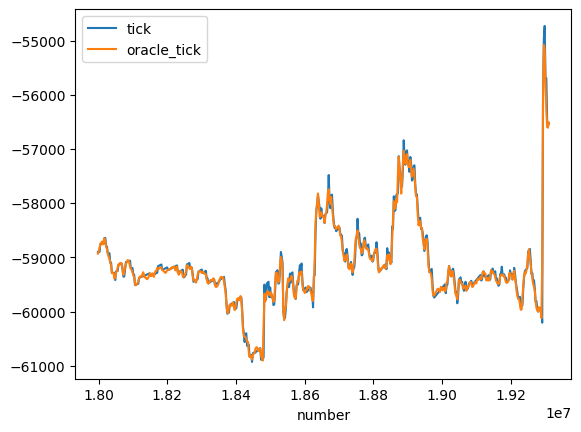

In [140]:
df.plot(x='number', y=['tick', 'oracle_tick'])

<Axes: xlabel='number'>

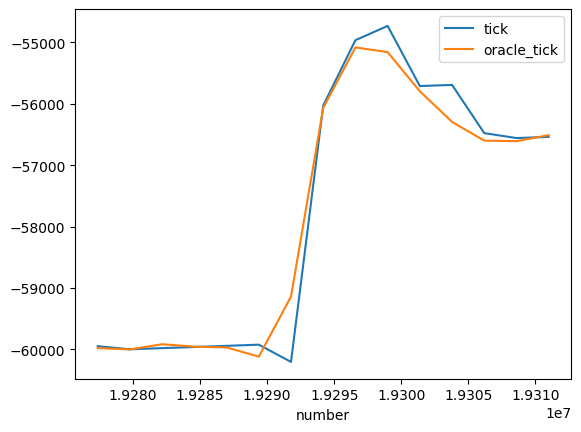

In [137]:
# zoom in to a 5 day window at end to see oracle tick timelag
# 12 hr TWAP lags so insurance mechanism for LPs must be robust to guarantee no bad debt
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['tick', 'oracle_tick'])

In [120]:
# plot mrgl pool price vs oracle time weighted average price over time
def calc_price_from_tick(tick: int) -> float:
    return 1.0001 ** tick

In [115]:
df['price'] = df['tick'].apply(calc_price_from_tick)
df['price']

0      0.002768
1      0.002767
2      0.002767
3      0.002809
4      0.002809
         ...   
543    0.003807
544    0.003815
545    0.003526
546    0.003498
547    0.003505
Name: price, Length: 548, dtype: float64

In [116]:
df['oracle_price'] = df['oracle_tick'].apply(calc_price_from_tick)
df['oracle_price']

0      0.002759
1      0.002770
2      0.002789
3      0.002808
4      0.002815
         ...   
543    0.003775
544    0.003591
545    0.003484
546    0.003480
547    0.003515
Name: oracle_price, Length: 548, dtype: float64

<Axes: xlabel='number'>

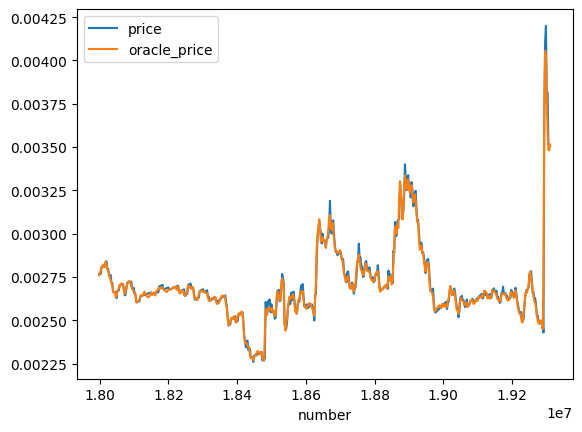

In [138]:
df.plot(x='number', y=['price', 'oracle_price'])

<Axes: xlabel='number'>

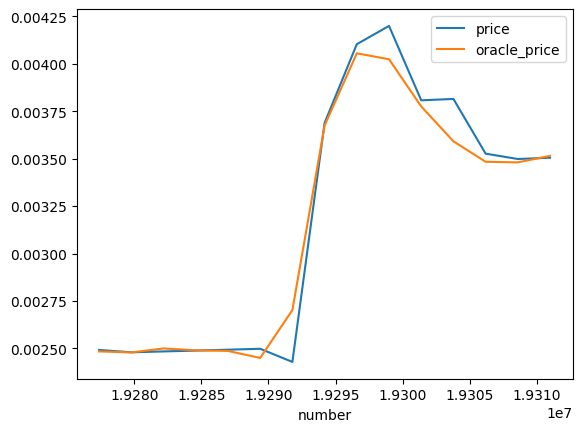

In [139]:
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['price', 'oracle_price'])

In [152]:
# plot liquidity gained over time. convert to datatype first
df['lp_total_liquidity'] = df['values3'].apply(lambda v: int(v))
df['lp_amount0'] = df['values4'].apply(lambda v: int(v))
df['lp_amount1'] = df['values5'].apply(lambda v: int(v))

In [153]:
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,_last_mrglv1_tick_cumulative,_net_liquidity_swap_fees_cumulative,_net_liquidity_position_fees_cumulative,tick,oracle_tick,price,oracle_price,lp_total_liquidity,lp_amount0,lp_amount1
0,17998182,1708998584,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,-1,0,0,-58900,-58932,0.002768,0.002759,10226805916623746957673,194397552620084053872985,538008621233460338723
1,18000582,1708998588,7670480545305599283587,4167684945538446847935294040,2556722172638830439092,10227202717944329718739,194420281185370240489050,537987471246382048461,4174832966775960060884034990,1348756457373625844877604,...,-236748,56581701727828008,327866112482406212,-58902,-58893,0.002767,0.002770,10227202717944329718739,194420281185370240489050,537987471246382048461
2,18002982,1709027524,7670499743743404731727,4167695376832776717667634751,2556722172638830439092,10227221916382135166692,194420159535830044032550,537989827683743229027,4198939390493444764294405442,1714990638571862423866014,...,-1704653906,75780139533276148,327866112482406212,-58902,-58825,0.002767,0.002789,10227221916382135166692,194420159535830044032550,537989827683743229027
3,18005382,1709056461,7670634839885648795376,4198873182948367358091477799,2556722172638830439092,10227357012524379229020,192979084667355752777740,542021595977263344813,4204231089501474711675342148,1665958413176292228814096,...,-3409129439,210876281777339797,327866112482406212,-58753,-58756,0.002809,0.002808,10227357012524379229020,192979084667355752777740,542021595977263344813
4,18007782,1709085433,7670775162980729748692,4198949995219213575614747188,2556722172638830439092,10227497335619460180964,192978202156075131445261,542038948344561510703,4208681782476437507208844991,1665958413176292228814096,...,-5111349957,351199376858293113,327866112482406212,-58752,-58732,0.002809,0.002815,10227497335619460180964,192978202156075131445261,542038948344561510703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724752468,10708538681596057067296,4888448243378506796571728060,3545778278765117556428,14254316960361035241736,231022869515911293205274,879504061360653370914,4875301928444821867630628907,323976533130863515655856,...,-932573553147,3554834574229818879934,10803464094282245086,-55711,-55796,0.003807,0.003775,14254316960361035241736,231022869515911293205274,879504061360653370914
544,19303782,1724781441,10718751381843618416744,4893110341361226278681782922,3545778278765117556428,14264529660608596491322,230968115431020901552184,880973575329496784961,4693924590733693082295585449,326421624029424835360987,...,-934187635858,3565047274477380229382,10803464094282245086,-55692,-56295,0.003815,0.003591,14264529660608596491322,230968115431020901552184,880973575329496784961
545,19306182,1724810462,10729190831949735795943,4704584952575536598475887701,3545778278765117556428,14274969110714713768441,240399436717717524603356,847650667963653154723,4685171427703644151759713962,327016644406246453261884,...,-935803898439,3575486724583497608581,10803464094282245086,-56478,-56600,0.003526,0.003484,14274969110714713768441,240399436717717524603356,847650667963653154723
546,19308582,1724839423,10739456685986716528329,4685939249805138538309078131,3545778278765117556428,14285234964751694400445,241529575397048358309930,844898342833165849767,4699914448871631640965677056,328647811298964781266544,...,-937439525394,3585752578620478340967,10803464094282245086,-56558,-56609,0.003498,0.003480,14285234964751694400445,241529575397048358309930,844898342833165849767


In [199]:
df['net_liquidity_settled_cumulative_zero_for_one'] = df['_net_liquidity_settled_cumulative0'].apply(lambda v: int(v))
df['net_liquidity_settled_cumulative_one_for_zero'] = df['_net_liquidity_settled_cumulative1'].apply(lambda v: int(v))
df['net_liquidity_settled_cumulative'] = df['net_liquidity_settled_cumulative_zero_for_one'] + df['net_liquidity_settled_cumulative_one_for_zero']

df['net_liquidity_liquidated_cumulative_zero_for_one'] = df['_net_liquidity_liquidated_cumulative0'].apply(lambda v: int(v))
df['net_liquidity_liquidated_cumulative_one_for_zero'] = df['_net_liquidity_liquidated_cumulative1'].apply(lambda v: int(v))
df['net_liquidity_liquidated_cumulative'] = df['net_liquidity_liquidated_cumulative_zero_for_one'] + df['net_liquidity_liquidated_cumulative_one_for_zero']

df['net_liquidity_swap_fees_cumulative'] = df['_net_liquidity_swap_fees_cumulative'].apply(lambda v: int(v))
df['net_liquidity_position_fees_cumulative'] = df['_net_liquidity_position_fees_cumulative'].apply(lambda v: int(v))
df['net_liquidity_fees_cumulative'] = df['net_liquidity_swap_fees_cumulative'] + df['net_liquidity_position_fees_cumulative']


In [200]:
df['net_liquidity_total_cumulative'] = df['lp_total_liquidity'] - df['lp_total_liquidity'].iloc[0]

In [201]:
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,net_liquidity_swap_fees_cumulative,net_liquidity_position_fees_cumulative,net_liquidity_settled_cumulative,net_liquidity_liquidated_cumulative,net_liquidity_total_cumulative,net_liquidity_fees_cumulative,yield_liquidity_total,yield_liquidity_fees,yield_liquidity_settled,yield_liquidity_liquidated
0,17998182,1708998584,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,18000582,1708998588,7670480545305599283587,4167684945538446847935294040,2556722172638830439092,10227202717944329718739,194420281185370240489050,537987471246382048461,4174832966775960060884034990,1348756457373625844877604,...,56581701727828008,327866112482406212,0,0,396801320582761066,384447814210234220,0.000039,0.000011,0.0,0.0
2,18002982,1709027524,7670499743743404731727,4167695376832776717667634751,2556722172638830439092,10227221916382135166692,194420159535830044032550,537989827683743229027,4198939390493444764294405442,1714990638571862423866014,...,75780139533276148,327866112482406212,0,0,415999758388209019,403646252015682360,0.000041,0.000015,0.0,0.0
3,18005382,1709056461,7670634839885648795376,4198873182948367358091477799,2556722172638830439092,10227357012524379229020,192979084667355752777740,542021595977263344813,4204231089501474711675342148,1665958413176292228814096,...,210876281777339797,327866112482406212,0,0,551095900632271347,538742394259746009,0.000054,0.000041,0.0,0.0
4,18007782,1709085433,7670775162980729748692,4198949995219213575614747188,2556722172638830439092,10227497335619460180964,192978202156075131445261,542038948344561510703,4208681782476437507208844991,1665958413176292228814096,...,351199376858293113,327866112482406212,0,0,691418995713223291,679065489340699325,0.000068,0.000069,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724752468,10708538681596057067296,4888448243378506796571728060,3545778278765117556428,14254316960361035241736,231022869515911293205274,879504061360653370914,4875301928444821867630628907,323976533130863515655856,...,3554834574229818879934,10803464094282245086,42019960565002341519,419415459168385434453,4027511043737288284063,3565638038324101125020,0.393819,0.695199,0.004109,0.041011
544,19303782,1724781441,10718751381843618416744,4893110341361226278681782922,3545778278765117556428,14264529660608596491322,230968115431020901552184,880973575329496784961,4693924590733693082295585449,326421624029424835360987,...,3565047274477380229382,10803464094282245086,42019960565002341519,419415459168385434453,4037723743984849533649,3575850738571662474468,0.394818,0.697197,0.004109,0.041011
545,19306182,1724810462,10729190831949735795943,4704584952575536598475887701,3545778278765117556428,14274969110714713768441,240399436717717524603356,847650667963653154723,4685171427703644151759713962,327016644406246453261884,...,3575486724583497608581,10803464094282245086,42019960565002341519,419415459168385434453,4048163194090966810768,3586290188677779853667,0.395838,0.699238,0.004109,0.041011
546,19308582,1724839423,10739456685986716528329,4685939249805138538309078131,3545778278765117556428,14285234964751694400445,241529575397048358309930,844898342833165849767,4699914448871631640965677056,328647811298964781266544,...,3585752578620478340967,10803464094282245086,42019960565002341519,419415459168385434453,4058429048127947442772,3596556042714760586053,0.396842,0.701246,0.004109,0.041011


In [202]:
# put in yield terms relative to initial liquidity
df['lp_total_liquidity'].iloc[0]

10226805916623746957673

In [203]:
df['yield_liquidity_total'] = (df['lp_total_liquidity'] / df['lp_total_liquidity'].iloc[0] - 1)
df['yield_liquidity_fees'] = (df['net_liquidity_fees_cumulative'] / df['lp_total_liquidity'].iloc[0])
df['yield_liquidity_settled'] = (df['net_liquidity_settled_cumulative'] / df['lp_total_liquidity'].iloc[0])
df['yield_liquidity_liquidated'] = (df['net_liquidity_liquidated_cumulative'] / df['lp_total_liquidity'].iloc[0])

In [204]:
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,net_liquidity_swap_fees_cumulative,net_liquidity_position_fees_cumulative,net_liquidity_settled_cumulative,net_liquidity_liquidated_cumulative,net_liquidity_total_cumulative,net_liquidity_fees_cumulative,yield_liquidity_total,yield_liquidity_fees,yield_liquidity_settled,yield_liquidity_liquidated
0,17998182,1708998584,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,18000582,1708998588,7670480545305599283587,4167684945538446847935294040,2556722172638830439092,10227202717944329718739,194420281185370240489050,537987471246382048461,4174832966775960060884034990,1348756457373625844877604,...,56581701727828008,327866112482406212,0,0,396801320582761066,384447814210234220,0.000039,0.000038,0.0,0.0
2,18002982,1709027524,7670499743743404731727,4167695376832776717667634751,2556722172638830439092,10227221916382135166692,194420159535830044032550,537989827683743229027,4198939390493444764294405442,1714990638571862423866014,...,75780139533276148,327866112482406212,0,0,415999758388209019,403646252015682360,0.000041,0.000039,0.0,0.0
3,18005382,1709056461,7670634839885648795376,4198873182948367358091477799,2556722172638830439092,10227357012524379229020,192979084667355752777740,542021595977263344813,4204231089501474711675342148,1665958413176292228814096,...,210876281777339797,327866112482406212,0,0,551095900632271347,538742394259746009,0.000054,0.000053,0.0,0.0
4,18007782,1709085433,7670775162980729748692,4198949995219213575614747188,2556722172638830439092,10227497335619460180964,192978202156075131445261,542038948344561510703,4208681782476437507208844991,1665958413176292228814096,...,351199376858293113,327866112482406212,0,0,691418995713223291,679065489340699325,0.000068,0.000066,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724752468,10708538681596057067296,4888448243378506796571728060,3545778278765117556428,14254316960361035241736,231022869515911293205274,879504061360653370914,4875301928444821867630628907,323976533130863515655856,...,3554834574229818879934,10803464094282245086,42019960565002341519,419415459168385434453,4027511043737288284063,3565638038324101125020,0.393819,0.348656,0.004109,0.041011
544,19303782,1724781441,10718751381843618416744,4893110341361226278681782922,3545778278765117556428,14264529660608596491322,230968115431020901552184,880973575329496784961,4693924590733693082295585449,326421624029424835360987,...,3565047274477380229382,10803464094282245086,42019960565002341519,419415459168385434453,4037723743984849533649,3575850738571662474468,0.394818,0.349655,0.004109,0.041011
545,19306182,1724810462,10729190831949735795943,4704584952575536598475887701,3545778278765117556428,14274969110714713768441,240399436717717524603356,847650667963653154723,4685171427703644151759713962,327016644406246453261884,...,3575486724583497608581,10803464094282245086,42019960565002341519,419415459168385434453,4048163194090966810768,3586290188677779853667,0.395838,0.350675,0.004109,0.041011
546,19308582,1724839423,10739456685986716528329,4685939249805138538309078131,3545778278765117556428,14285234964751694400445,241529575397048358309930,844898342833165849767,4699914448871631640965677056,328647811298964781266544,...,3585752578620478340967,10803464094282245086,42019960565002341519,419415459168385434453,4058429048127947442772,3596556042714760586053,0.396842,0.351679,0.004109,0.041011


<Axes: xlabel='number'>

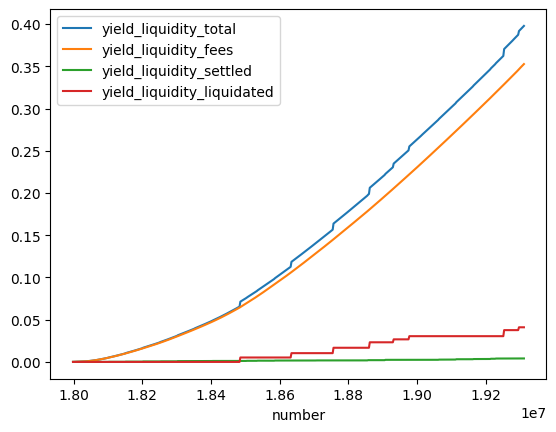

In [205]:
df.plot(x='number', y=['yield_liquidity_total', 'yield_liquidity_fees', 'yield_liquidity_settled', 'yield_liquidity_liquidated'])

<Axes: xlabel='number'>

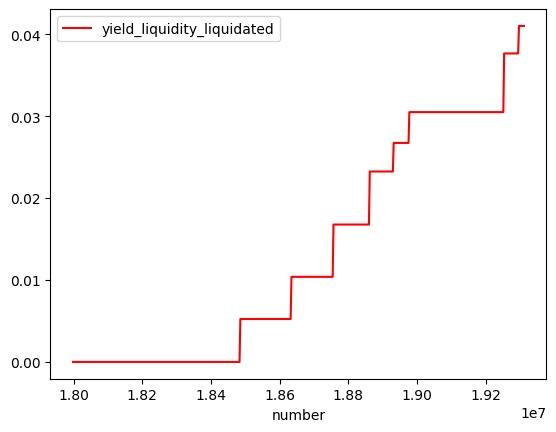

In [209]:
# look at net liquidity liquidated over time and check no shortfalls due to liquidations (i.e. no bad debt)
df.plot(x='number', y=['yield_liquidity_liquidated'], color=['r'])

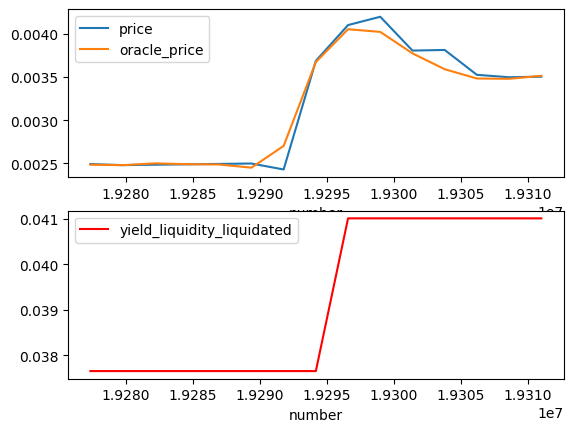

In [216]:
# focus on last 5 day window ...
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-price_vs_liquidations_yield_T-5.png"
fig, ax = plt.subplots(2, 1)
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['price', 'oracle_price'], ax=ax[0])
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['yield_liquidity_liquidated'], color=['r'], ax=ax[1])
fig.savefig(fp)